In [1]:
# This ensures to use the source code if not installed as Python package
try:
    import rapidAlignerSeismic
except:
    import os, sys
    sys.path.append(os.path.join(os.getcwd(),".."))

This notebooks shows the basics of RAS by running a very basic example (one station, one component).
The data comes from the Chilean permanent network (network code: C1, station code MT03)

In [2]:
import rapidAlignerSeismic as ras
import cupy as cp
import numpy as np
import pylab as pl

In [3]:
#Default values
# -------------------------------------------------------------------------------
#Repository containing data
template_dir = '../data/templates_chile'
wf_dir       = '../data/wf_chile'

#Repository to write results
output_dir = '../data/corr'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

#Station informations 
network = 'C1'
station = 'MT03'
channel = 'HHZ'
jday    = '2018.053'
# -------------------------------------------------------------------------------

In [4]:
#Signal parameters
# -------------------------------------------------------------------------------
# Pass filter corner frequencies [Hz] (Float, Integer)
fmin = 2
fmax = 20
# Decimation flag (Boolean, True or False)
decimate = False

In [5]:
#Load daily and template and perform a copy on GPU
dailySig, dailySr, dailyTbeg, dailyTend = ras.util.DailyLoader(wf_dir+'/'+network+'.'+station+'.00.'+channel+'.D.'+jday, fmin, fmax, decimate).data 
dailySig_gpu      = cp.asarray(dailySig)

#template, template length, template sampling rate
templateSig, templateLen, templateSr  = ras.util.TemplateLoader(template_dir+'/'+network+'.'+station+'.00.'+channel+'.D.'+jday+'*', fmin, fmax, decimate).data
templateSig_gpu                       = cp.asarray(templateSig)

if dailySr != templateSr:
    print('Sampling rate for both template and stream must be the same!')

In [6]:
#Perform template matching
#Using Rolling mean- and amplitude-adjusted Euclidean Distance using FFT ##TO DO MODIF: on ne calcule que correlation à terme
dist , corr = ras.ED.zdist(templateSig_gpu, dailySig_gpu, mode="fft")

#Write results
# save to binary files
corr = corr.astype('float32')
cp.save(output_dir+'/corr.'+network+'.'+station+'.'+channel+'.'+jday+'.npy', corr)

detection treshold= 0.14
normalized correlation coefficients


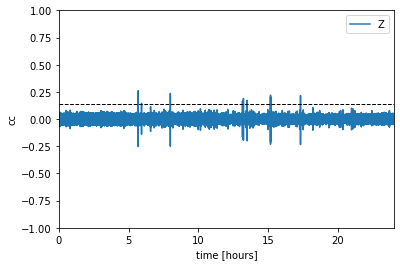

find matches...
cleanup matches...
0 2018-02-22T05:40:59.020000Z 0.26
1 2018-02-22T05:55:12.510000Z 0.15
2 2018-02-22T07:59:05.360000Z 0.24
3 2018-02-22T13:09:21.810000Z 0.17
4 2018-02-22T13:11:07.970000Z 0.17
5 2018-02-22T13:13:27.970000Z 0.19
6 2018-02-22T13:29:03.140000Z 0.17
7 2018-02-22T15:09:58.880000Z 0.22
8 2018-02-22T15:10:24.240000Z 0.20
9 2018-02-22T17:18:56.110000Z 0.22
Plotting clean matches for station MT03


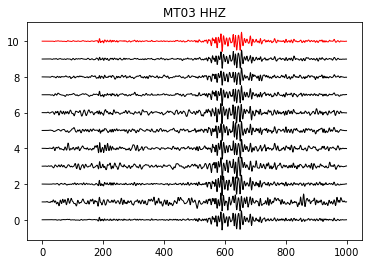

In [7]:
#Plot and show detection given a certain treshold
#fixed value
#treshold = 0.25

# Dynamic treshold based on mean average deviation (MAD)
mad = cp.mean(cp.absolute(corr - cp.median(corr)))
treshold = float((mad * 15) / templateLen)
print('detection treshold=', '{:4.2f}'.format(treshold))

ras.util.plot_match(network, station, channel, jday, templateLen, templateSr, treshold, output_dir, wf_dir)

The last figure should display the corresponding detections (black) and the stacked strace (red) with normalized amplitudes. Because we are using one component, the level of noise is quite high and lowering the detection treshold would result in false detections. In the next example, we will see that it is possible to improve the level of detection by performing a multi-component stack.